# Does SATD in commit messages correlate with high code complexity?
### Investigate commit messages for SATD related keywords, inspect changes for complexity.

In this analysis, we will investigate whether self-admitted technical debt (SATD) in commit messages correlates with high code complexity. Specifically, we will examine how code complexity changes when SATD increases compared to when it doesn't. We will perform the following steps:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_context("notebook", font_scale=1.2)
colors = ["#4878D0", "#6ACC65"]
sns.set_palette(colors)

In [3]:
# Load the dataset
df = pd.read_csv('combined_method_analysis (1).csv')

# Ensure the required columns exist
assert {'commit_message_contains_SATD', 'complexity_change', 'commit_hash'}.issubset(df.columns), "Required columns missing!"

# Print basic dataset information
print(f"Total methods analyzed: {len(df)}")
print(f"Total commits: {df['commit_hash'].nunique()}")
print(f"Commits with SATD: {df[df['commit_message_contains_SATD']]['commit_hash'].nunique()}")
print(f"Commits without SATD: {df[~df['commit_message_contains_SATD']]['commit_hash'].nunique()}")

# Split data into two groups
satd_in_message = df[df['commit_message_contains_SATD']]['complexity_change']
no_satd_in_message = df[~df['commit_message_contains_SATD']]['complexity_change']


Total methods analyzed: 12968
Total commits: 5312
Commits with SATD: 435
Commits without SATD: 4877



## Complexity Change Statistics:
SATD in Commit Message - Mean: 0.21, Median: 1.00
No SATD in Commit Message - Mean: 0.47, Median: 1.00


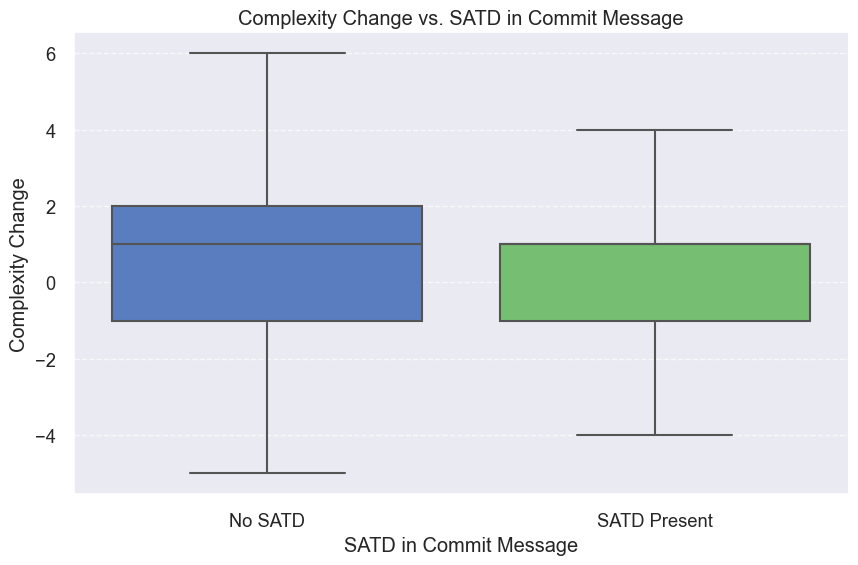

In [4]:
# Compute summary statistics
print("\n## Complexity Change Statistics:")
print(f"SATD in Commit Message - Mean: {satd_in_message.mean():.2f}, Median: {satd_in_message.median():.2f}")
print(f"No SATD in Commit Message - Mean: {no_satd_in_message.mean():.2f}, Median: {no_satd_in_message.median():.2f}")

# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='commit_message_contains_SATD', y='complexity_change', data=df, showfliers=False)
plt.xlabel('SATD in Commit Message')
plt.ylabel('Complexity Change')
plt.title('Complexity Change vs. SATD in Commit Message')
plt.xticks([0, 1], ['No SATD', 'SATD Present'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
# Test for normality using Shapiro-Wilk
print("\n## Normality Test (Shapiro-Wilk):")
np.random.seed(42)  # Ensures reproducibility
satd_sample = satd_in_message.sample(min(1000, len(satd_in_message))) if len(satd_in_message) > 1000 else satd_in_message
no_satd_sample = no_satd_in_message.sample(min(1000, len(no_satd_in_message))) if len(no_satd_in_message) > 1000 else no_satd_in_message

_, p_satd = shapiro(satd_sample)
_, p_no_satd = shapiro(no_satd_sample)

print(f"SATD Group: p-value = {p_satd:-10e}")
print(f"No SATD Group: p-value = {p_no_satd:-10e}")



## Normality Test (Shapiro-Wilk):
SATD Group: p-value = 1.848453e-41
No SATD Group: p-value = 3.222986e-44


In [15]:
# Select appropriate test
alpha = 0.05
if p_satd > alpha and p_no_satd > alpha:
    print("\nUsing **t-test** (data is normally distributed)")
    stat_test, p_value = ttest_ind(satd_in_message, no_satd_in_message, equal_var=False)
    test_name = "Independent t-test"
else:
    print("\nUsing **Mann-Whitney U test** (data is not normal)")
    stat_test, p_value = mannwhitneyu(satd_in_message, no_satd_in_message)
    test_name = "Mann-Whitney U test"

print(f"{test_name}: Statistic = {stat_test:.4f}, p-value = {p_value:-10e}")



Using **Mann-Whitney U test** (data is not normal)
Mann-Whitney U test: Statistic = 7056663.5000, p-value = 1.124635e-07


In [17]:
# Interpretation
if p_value < alpha:
    print(f"\n There is a statistically significant difference in complexity changes between commits with and without SATD (p < {alpha}).")
else:
    print(f"\n No significant difference in complexity changes between commits with and without SATD (p > {alpha}).")

# Aggregate commit-level data
commit_data = df.groupby('commit_hash').agg({
    'complexity_change': 'mean',
    'commit_message_contains_SATD': 'first'
}).reset_index()



 There is a statistically significant difference in complexity changes between commits with and without SATD (p < 0.05).


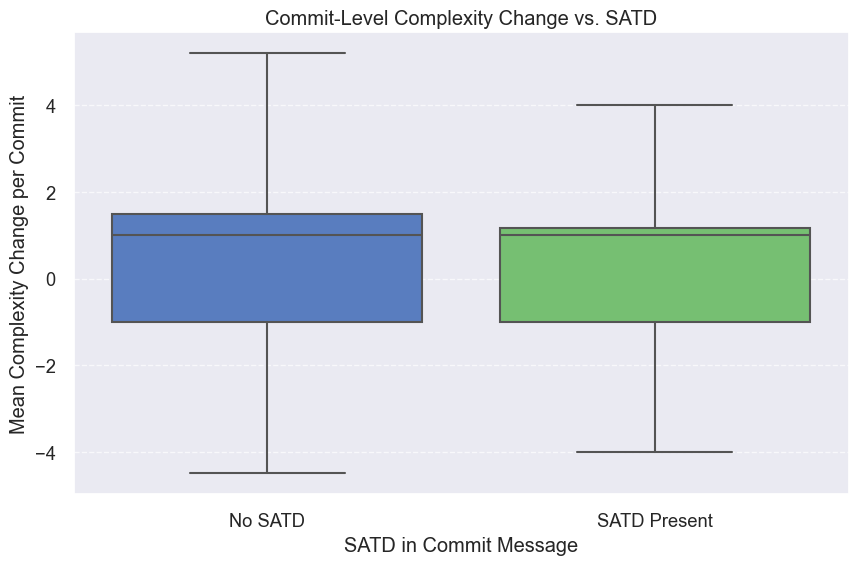

In [18]:
# Commit-level boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='commit_message_contains_SATD', y='complexity_change', data=commit_data, showfliers=False)
plt.xlabel('SATD in Commit Message')
plt.ylabel('Mean Complexity Change per Commit')
plt.title('Commit-Level Complexity Change vs. SATD')
plt.xticks([0, 1], ['No SATD', 'SATD Present'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('rq2_commit_level_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Commit-level statistical analysis
satd_commits = commit_data[commit_data['commit_message_contains_SATD']]['complexity_change']
no_satd_commits = commit_data[~commit_data['commit_message_contains_SATD']]['complexity_change']


In [19]:
_, p_commit_satd = shapiro(satd_commits.sample(min(1000, len(satd_commits))) if len(satd_commits) > 1000 else satd_commits)
_, p_commit_no_satd = shapiro(no_satd_commits.sample(min(1000, len(no_satd_commits))) if len(no_satd_commits) > 1000 else no_satd_commits)

if p_commit_satd > alpha and p_commit_no_satd > alpha:
    commit_stat, commit_p_value = ttest_ind(satd_commits, no_satd_commits, equal_var=False)
    commit_test_name = "Independent t-test"
else:
    commit_stat, commit_p_value = mannwhitneyu(satd_commits, no_satd_commits)
    commit_test_name = "Mann-Whitney U test"

print(f"\n## Commit-Level Statistical Analysis:")
print(f"{commit_test_name}: Statistic = {commit_stat:.4f}, p-value = {commit_p_value:.6f}")



## Commit-Level Statistical Analysis:
Mann-Whitney U test: Statistic = 997458.5000, p-value = 0.035172


In [23]:
# Final Interpretation
print("\n### Final Summary for RQ2:")
if p_value < alpha:
    print(f"- Method Level: There is a significant difference in complexity changes (p = {p_value:-10e}).")
else:
    print(f"- Method Level: No significant difference in complexity changes (p = {p_value:-10e}).")

if commit_p_value < alpha:
    print(f"- Commit Level: There is a significant difference in mean complexity changes (p = {commit_p_value:-10e}).")
else:
    print(f"- Commit Level: No significant difference in mean complexity changes (p = {commit_p_value:-10e}).")

print("\n Key Takeaway: If SATD in commit messages correlates with complexity change, the effect size should be examined to determine its practical significance.")


### Final Summary for RQ2:
- Method Level: There is a significant difference in complexity changes (p = 1.124635e-07).
- Commit Level: There is a significant difference in mean complexity changes (p = 3.517179e-02).

 Key Takeaway: If SATD in commit messages correlates with complexity change, the effect size should be examined to determine its practical significance.
